#### Normal CNN for the Bird classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
DIR_TRAIN = '../Data/Use/Preprocessed/Augmented/'
DIR_TEST = '../Data/Use/Test/'
DIR_VALID = '../Data/Use/Valid/'

In [4]:
os.listdir(DIR_TRAIN)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(100,100), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

test_datagen = test_datagen.flow_from_directory(DIR_TEST,
                                                target_size=(100,100),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=16,
                                                shuffle=True)

valid_datagen = valid_datagen.flow_from_directory(DIR_VALID,
                                                target_size=(100,100), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

Found 2000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer = [
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(3,3)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=50, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='softmax')
        ]

    def call(self, x):

        for i in self.layer:
            x = i(x)
        return x

In [7]:
net = ConvNet()

net.build(input_shape=(16, 100, 100, 3))
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
net.summary()

Model: "conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  184

In [9]:
net.fit(train_datagen, epochs=50, validation_data=valid_datagen)

Epoch 1/50
125/125 [==============================] - 8s 25ms/step - loss: 2.2128 - accuracy: 0.2470 - val_loss: 3.2511 - val_accuracy: 0.2000
Epoch 2/50
125/125 [==============================] - 2s 16ms/step - loss: 1.6371 - accuracy: 0.4375 - val_loss: 1.9799 - val_accuracy: 0.4400
Epoch 3/50
125/125 [==============================] - 2s 16ms/step - loss: 1.3501 - accuracy: 0.5530 - val_loss: 1.5503 - val_accuracy: 0.4400
Epoch 4/50
125/125 [==============================] - 2s 16ms/step - loss: 1.1062 - accuracy: 0.6230 - val_loss: 1.1670 - val_accuracy: 0.6200
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.8866 - accuracy: 0.6940 - val_loss: 1.2376 - val_accuracy: 0.6200
Epoch 6/50
125/125 [==============================] - 2s 15ms/step - loss: 0.6621 - accuracy: 0.7785 - val_loss: 1.0015 - val_accuracy: 0.6400
Epoch 7/50
125/125 [==============================] - 2s 16ms/step - loss: 0.5596 - accuracy: 0.8200 - val_loss: 1.2700 - val_accuracy: 0.6200

In [10]:
net.evaluate(test_datagen)

4/4 [==============================] - 0s 83ms/step - loss: 1.4428 - accuracy: 0.8000


[1.4428091049194336, 0.800000011920929]

#### Predicting a bird

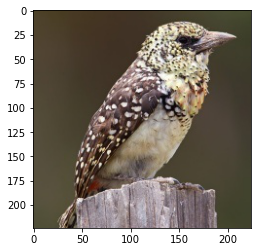

In [49]:
# Load a random image
path = np.random.choice(os.listdir(DIR_VALID))
img = np.random.choice(os.listdir(DIR_VALID + path))
img = Image.open(DIR_VALID + path + '/' + img)

plt.imshow(img)

img = tf.expand_dims(img, 0)
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, (100,100))
img = img / 255.0

In [50]:
preds = net.predict(img)
preds_dict = {}

for n,i in enumerate(preds[0]):
    preds_dict[os.listdir(DIR_VALID)[n]] = i

preds_dict = sorted(preds_dict.items(), key=lambda x: x[1], reverse=True)

print('Actual:', path, '- Predicted:', os.listdir(DIR_VALID)[np.argmax(preds[0])],'\n')

for i in preds_dict:
    print(f'{i[1]:.2f}', i[0])

Actual: D-ARNAUDS BARBET - Predicted: D-ARNAUDS BARBET 

1.00 D-ARNAUDS BARBET
0.00 HOUSE FINCH
0.00 RED TAILED HAWK
0.00 OVENBIRD
0.00 WOOD DUCK
0.00 DARK EYED JUNCO
0.00 VIOLET GREEN SWALLOW
0.00 CASPIAN TERN
0.00 SWINHOES PHEASANT
0.00 OYSTER CATCHER


#### Confusion Matrix

In [13]:
X = np.concatenate([train_datagen.next()[0] for i in range(train_datagen.__len__())])
Y = np.concatenate([train_datagen.next()[1] for i in range(train_datagen.__len__())])
print(X.shape, Y.shape)

(1000, 100, 100, 3) (1000, 10)


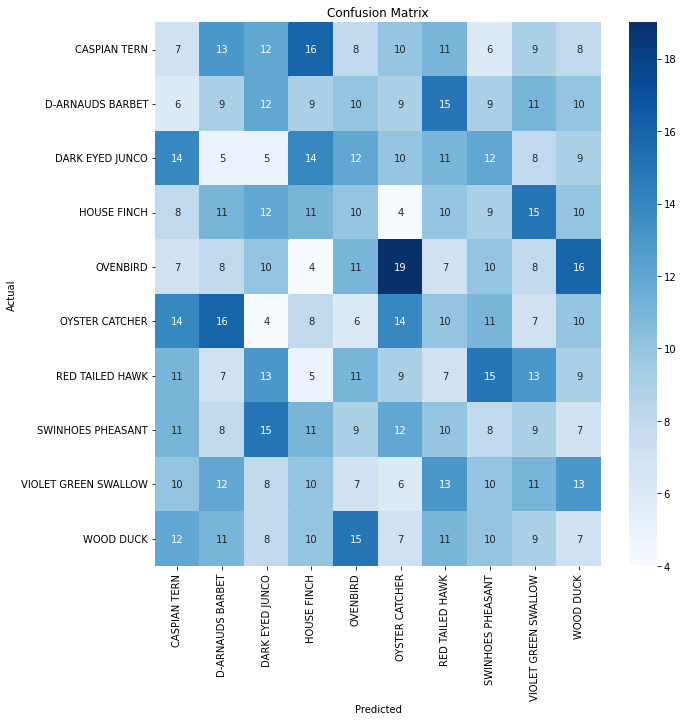

In [14]:
from sklearn.manifold import TSNE
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

# Make a confusion matrix
conf = confusion_matrix(np.argmax(Y, axis=1), np.argmax(net.predict(X), axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(DIR_VALID), yticklabels=os.listdir(DIR_VALID))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
